In [188]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns



import json
import time
import random
import datetime as dt
from datetime import timedelta


from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import RandomizedLasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import sklearn.cross_validation
from sklearn import lda
from sklearn import qda
from sklearn import tree
from sklearn import cluster
from sklearn import metrics
from sklearn import cross_validation


In [189]:
def one_hot_code_strings(df):
    count = 0
    include = ['city', 'phone','uber_black_user']
    for i in df:
        if i in include:        
            dummies = pd.get_dummies(df[i])
            for j in dummies:
                name = j
                df[name] = dummies[j]
    t = df
    for i in t:
        if i in include:
            t = t.drop(i, 1)
    df = t
    return df

def time_preprocessing(df):
    column_name = 'signup_date'
    
    times = []
    for i in df[column_name]:
        times.append(time.strptime(str(i), "%Y-%m-%d %H:%M:%S"))

    day = []
    for i in times:
        day.append(i[2])


    df['signup_day'] = day
    df.drop([column_name], axis=1)
    return df

parsed_json = json.loads(open('uber_data_challenge.json').read())
df = pd.DataFrame(parsed_json)
df['signup_date'] = df.signup_date.astype('datetime64')
df['last_trip_date'] = df.last_trip_date.astype('datetime64')

df = one_hot_code_strings(df)
df = time_preprocessing(df)

retained = []
cutoff = max(df['last_trip_date']) - timedelta(days = 30)
for i in df.last_trip_date:
    if i > cutoff:
        retained.append(1.0)
    else:
        retained.append(0.0)
df['retained'] = retained

df = df.drop(['last_trip_date', 'signup_date'], 1)

df[:5]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone,False,True,signup_day,retained
0,3.67,5.0,4.7,1.10,15.4,4,46.2,0,1,0,0,1,0,1,25,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,1,0,0,1,0,1,0,29,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,1,0,0,0,1,1,0,6,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,0,1,0,0,1,0,1,10,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,1,1,0,1,0,27,0


In [87]:
print "Percentage Retained = %.2f%%" %(100*sum(retained)/float(len(df)))

Percentage Retained = 36.62%


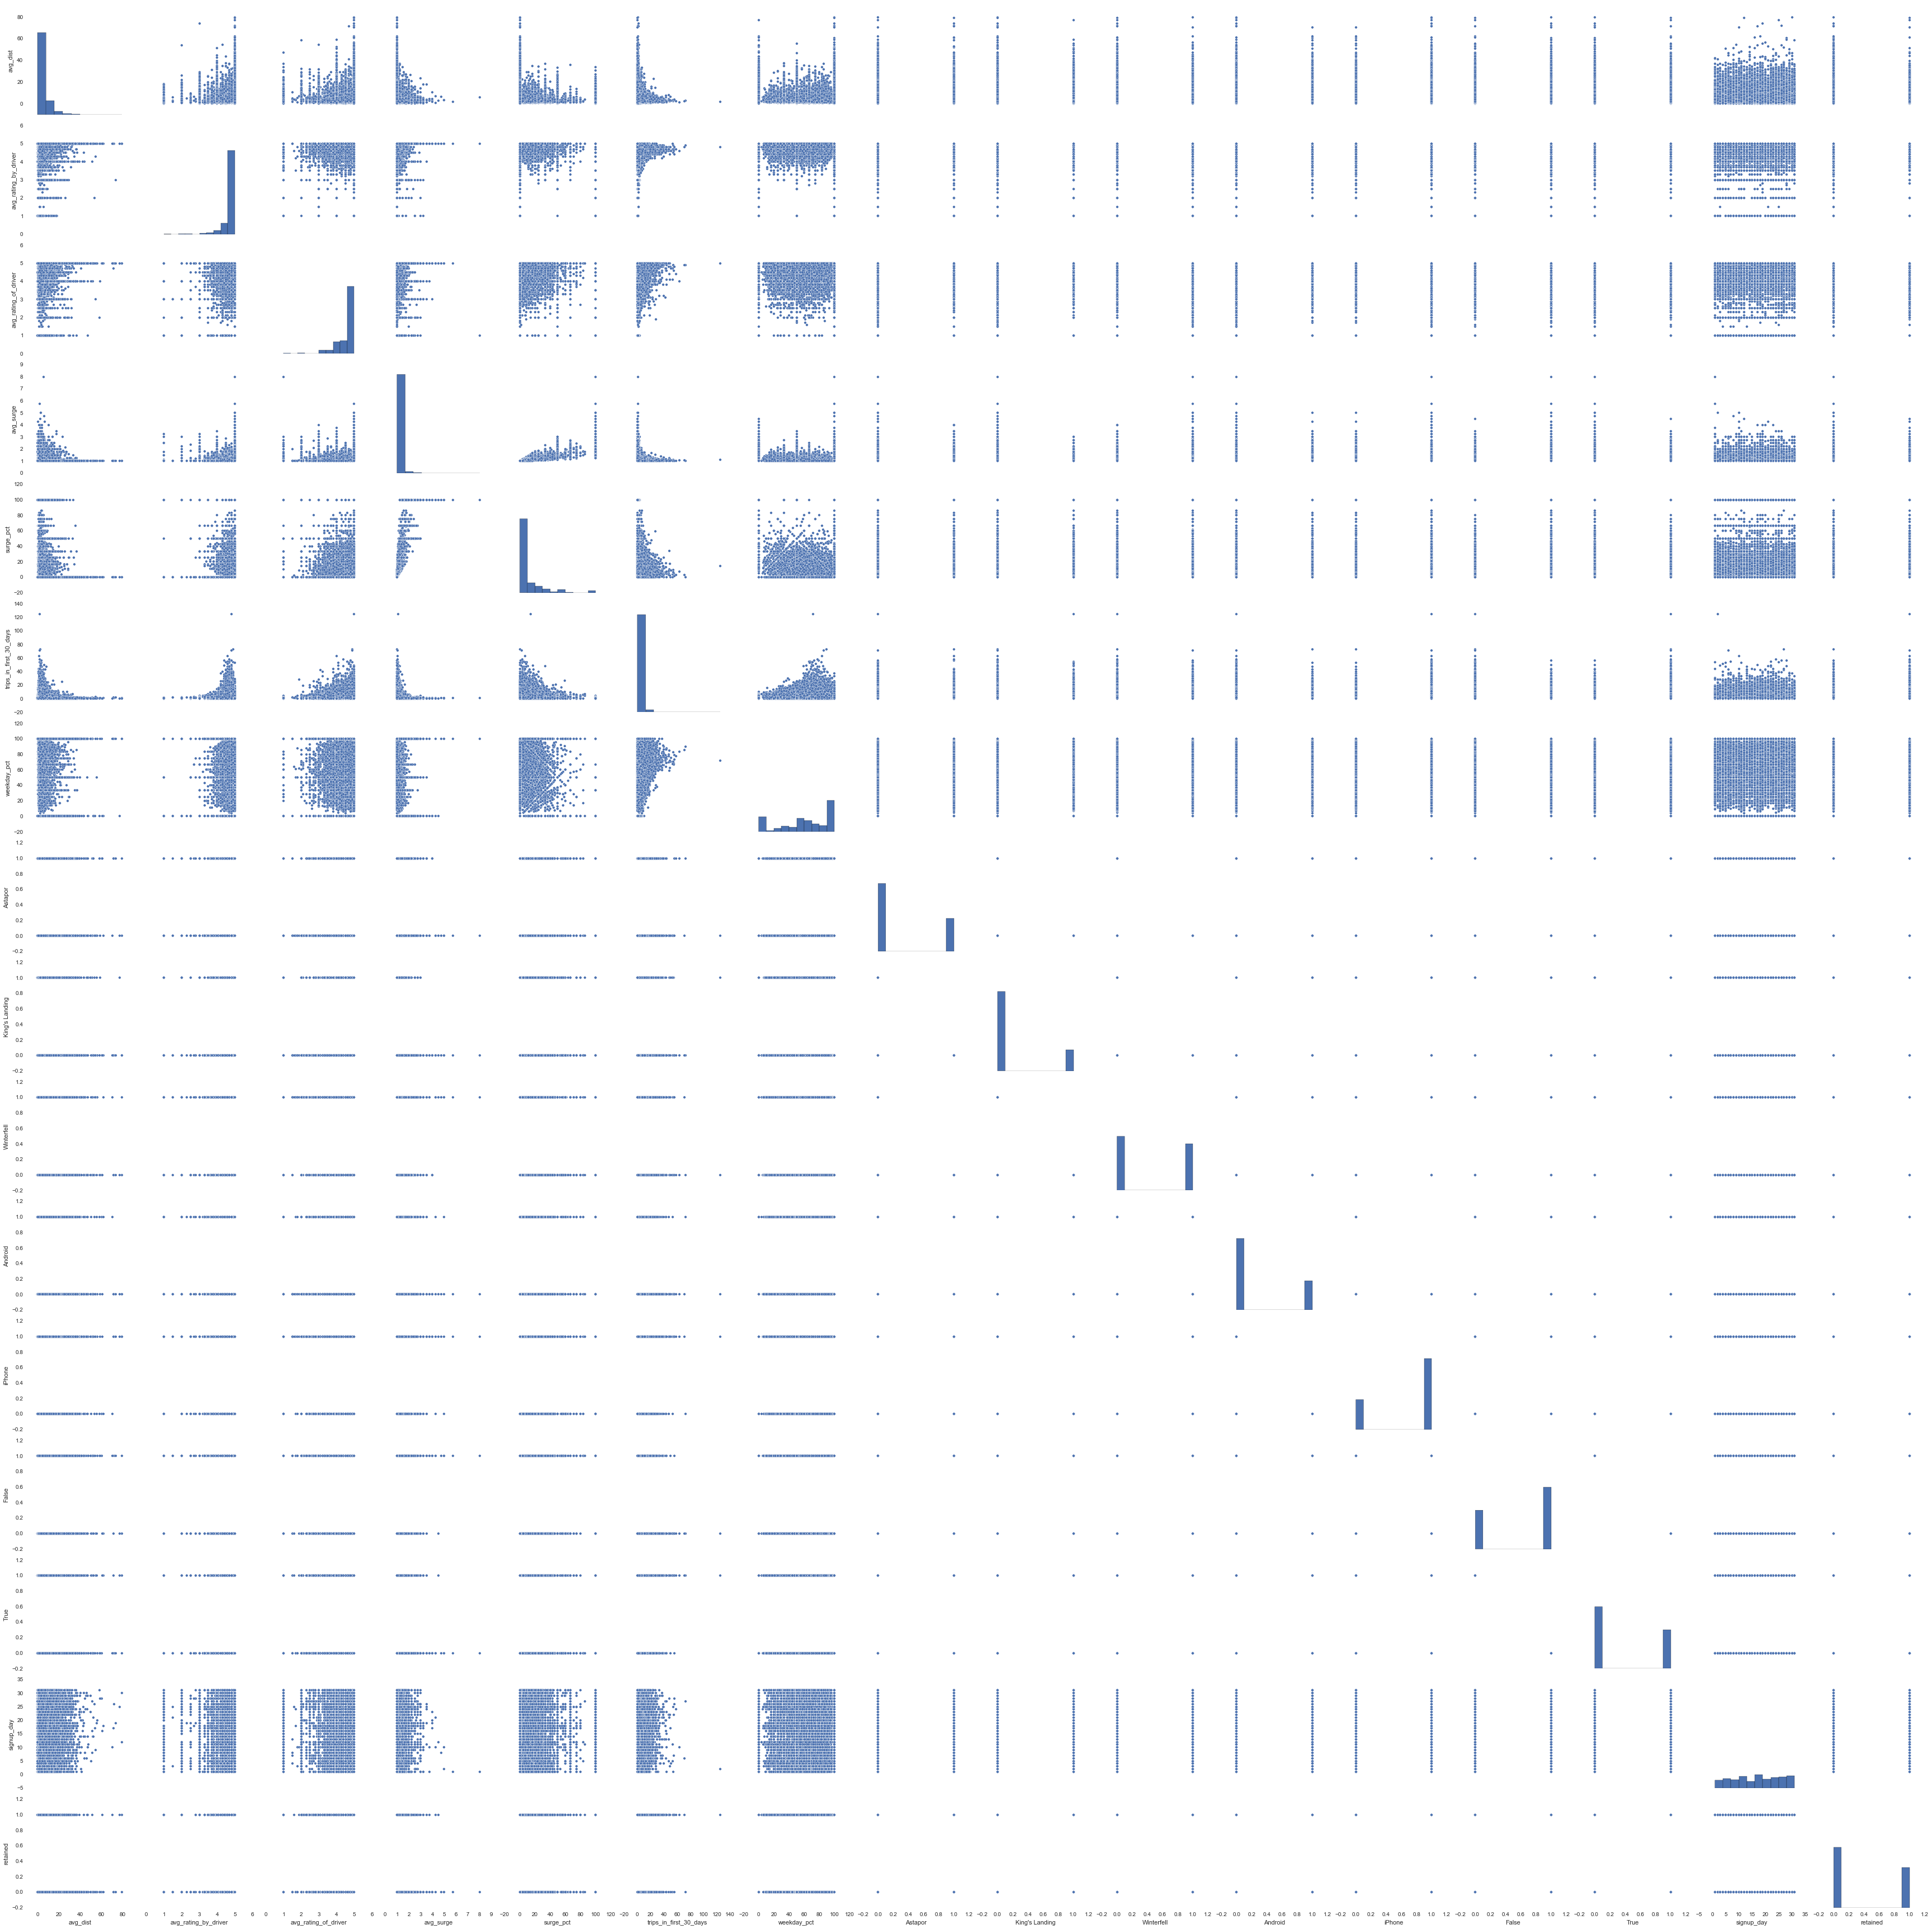

In [88]:
without_na = df.dropna()
sns.pairplot(without_na)

In [89]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,Astapor,King's Landing,Winterfell,Android,iPhone,False,True,signup_day,retained
avg_dist,1.000000,0.080540,0.034509,-0.081491,-0.104414,-0.136329,0.101652,-0.045431,0.015877,0.030050,0.020888,-0.025030,-0.032310,0.032310,0.017274,-0.090279
avg_rating_by_driver,0.080540,1.000000,0.123175,0.010597,0.020103,-0.039115,0.020442,0.032580,0.084648,-0.098929,0.008783,-0.010148,-0.009343,0.009343,0.002201,-0.025635
avg_rating_of_driver,0.034509,0.123175,1.000000,-0.026189,-0.003899,-0.011302,0.014630,0.032699,0.088392,-0.103100,0.026729,-0.026864,0.002086,-0.002086,0.006565,-0.010834
avg_surge,-0.081491,0.010597,-0.026189,1.000000,0.793582,-0.001841,-0.110071,0.037172,-0.009198,-0.027643,-0.008977,0.011104,0.078791,-0.078791,-0.006944,-0.003567
surge_pct,-0.104414,0.020103,-0.003899,0.793582,1.000000,0.005720,-0.144918,0.045457,0.028221,-0.065603,-0.010150,0.012851,0.106861,-0.106861,0.001667,0.010612
trips_in_first_30_days,-0.136329,-0.039115,-0.011302,-0.001841,0.005720,1.000000,0.050388,-0.061075,0.024650,0.037735,-0.059309,0.058342,-0.112210,0.112210,0.012351,0.214728
weekday_pct,0.101652,0.020442,0.014630,-0.110071,-0.144918,0.050388,1.000000,-0.010540,0.031349,-0.015318,-0.009241,0.006726,-0.035998,0.035998,0.007367,0.026413
Astapor,-0.045431,0.032580,0.032699,0.037172,0.045457,-0.061075,-0.010540,1.000000,-0.354298,-0.657563,0.025642,-0.024539,-0.021259,0.021259,0.017547,-0.179373
King's Landing,0.015877,0.084648,0.088392,-0.009198,0.028221,0.024650,0.031349,-0.354298,1.000000,-0.471555,-0.059203,0.060520,-0.039649,0.039649,0.025171,0.268272
Winterfell,0.030050,-0.098929,-0.103100,-0.027643,-0.065603,0.037735,-0.015318,-0.657563,-0.471555,1.000000,0.023517,-0.025618,0.051990,-0.051990,-0.036826,-0.046985


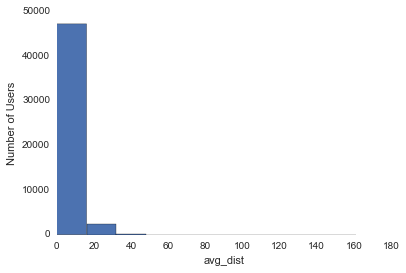

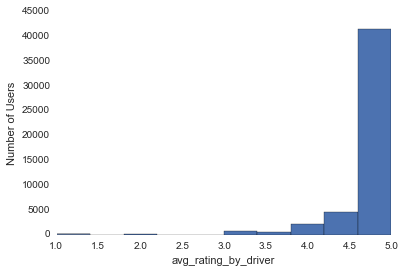

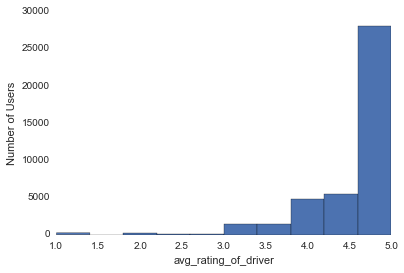

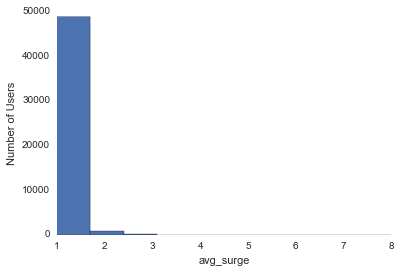

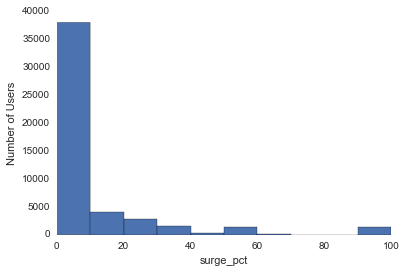

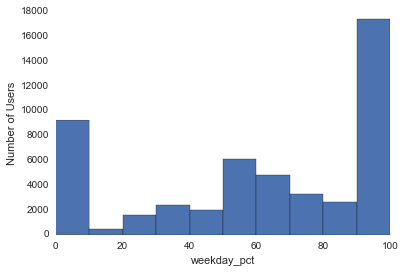

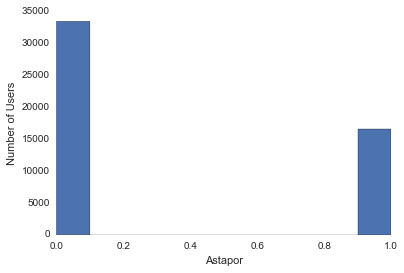

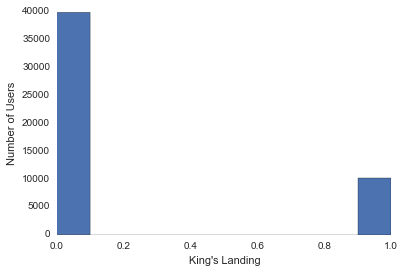

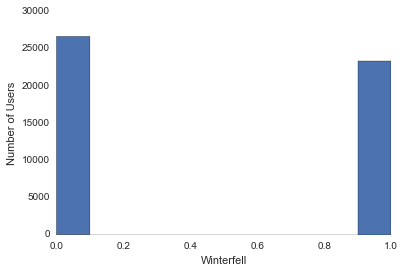

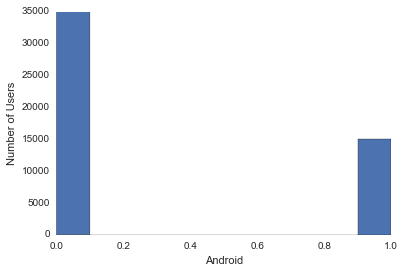

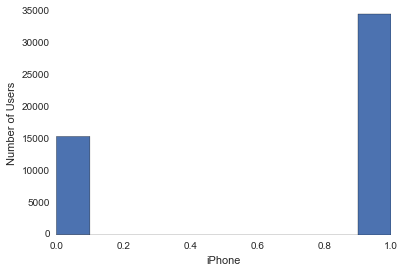

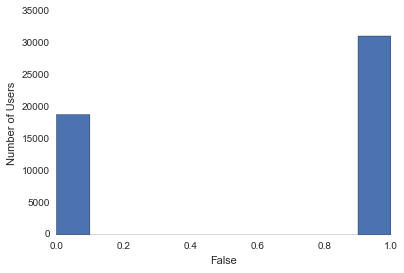

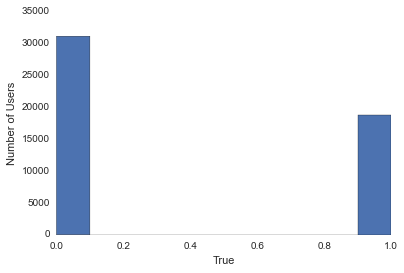

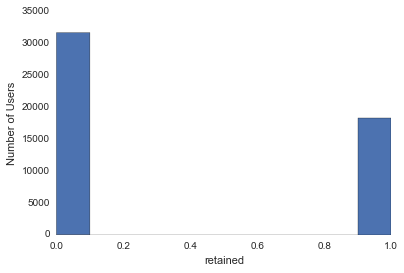

In [90]:
for i in df:
    if type(df[i][0]) == np.float64:
        plt.hist(df[i].dropna())
        plt.title('Distribution of' i)
        plt.ylabel('Number of Users')
        plt.xlabel(i)
        plt.show()

In [168]:
# interaction_terms = pd.DataFrame()
# df = df.rename(columns = {True:'true'})
# # Drop Collinear Bool Variable
# df = df.drop(False, 1)
# df_copy = df.copy()
# for i in df:
#     for j in df:
#         interaction_terms[i + '*' + j] = df[i]*df_copy[j]
        
# important_interactions = pd.DataFrame(interaction_terms, columns=['true*true','Android*avg_surge','avg_surge*iPhone','weekday_pct*weekday_pct','King\'s Landing*avg_rating_by_driver','avg_rating_by_driver*King\'s Landing',
#  'avg_rating_by_driver*surge_pct','avg_surge*surge_pct'])
# df = pd.concat([df, important_interactions], axis = 1)

In [190]:
"""
Prepare for Modeling
"""
df = df.rename(columns = {True:'true'})
df = df.drop(False, 1)
df = df.dropna()
y = df['retained']
df = df.drop('retained', 1)

preprocessing_array = []
for i in df:
    preprocessing_array.append([i, df[i].mean(), df[i].std()])
    df[i] = df[i]/float(df[i].std())
    df[i] = df[i] - df[i].mean()

In [191]:
cluster_columns = ['Astapor','signup_day','King\'s Landing',
 'trips_in_first_30_days','avg_dist','surge_pct']

for_cluster = pd.DataFrame(df, columns = cluster_columns)

preprocessing_array = []
for i in for_cluster:
    preprocessing_array.append([i, for_cluster[i].mean(), for_cluster[i].std()])
    for_cluster[i] = for_cluster[i]/float(for_cluster[i].std())
    for_cluster[i] = for_cluster[i] - for_cluster[i].mean()
    
kmeans = cluster.KMeans(n_clusters = 10, init='k-means++')

df['clusters'] = kmeans.fit_predict(for_cluster)
dummies = pd.get_dummies(df['clusters'])
for j in dummies:
    df[str(j) + '_k-means++'] = dummies[j]/float((dummies[j]-dummies[j].mean()).std())
df = df.drop(['clusters'], axis=1)

In [192]:
x = df
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(x, y, test_size = .2, random_state = 42)
x_train = pd.DataFrame(x_train, columns = x.columns)
x_test = pd.DataFrame(x_test, columns = x.columns)
x_train_stacking = x_train[:len(x_train)/2]
y_train_stacking = y_train[:len(y_train)/2]
x_train = x_train[len(x_train)/2:]
y_train = y_train[len(y_train)/2:]

In [193]:
stacking_forest = ensemble.RandomForestRegressor(n_estimators=400)
stacking_forest.fit(x_train_stacking, y_train_stacking)
stacking_forest_predictions_train = stacking_forest.predict(x_train)
stacking_forest_predictions_test = stacking_forest.predict(x_test) 

stacking_booster = ensemble.GradientBoostingRegressor(n_estimators=100)
stacking_booster.fit(x_train_stacking, y_train_stacking)
stacking_booster_predictions_train = stacking_booster.predict(x_train)
stacking_booster_predictions_test = stacking_booster.predict(x_test) 

bayesian_ridge = linear_model.BayesianRidge()
bayesian_ridge.fit(x_train_stacking, y_train_stacking)
stacking_ridge_predictions_train = bayesian_ridge.predict(x_train)
stacking_ridge_predictions_test = bayesian_ridge.predict(x_test)

extra = ensemble.ExtraTreesRegressor(n_estimators=400)
extra.fit(x_train_stacking, y_train_stacking)
stacking_extra_predictions_train = extra.predict(x_train)
stacking_extra_predictions_test = extra.predict(x_test)

In [194]:
x_train['stacking_forest_predictions'] = stacking_forest_predictions_train
x_test['stacking_forest_predictions'] = stacking_forest_predictions_test
x_train['stacking_booster_predictions'] = stacking_booster_predictions_train
x_test['stacking_booster_predictions'] = stacking_booster_predictions_test
x_train['stacking_ridge_predictions'] = stacking_ridge_predictions_train
x_test['stacking_ridge_predictions'] = stacking_ridge_predictions_test
x_train['stacking_extra_predictions'] = stacking_extra_predictions_train
x_test['stacking_extra_predictions'] = stacking_extra_predictions_test

In [206]:
booster = ensemble.GradientBoostingClassifier(n_estimators = 200)
booster = booster.fit(x_train, y_train)
booster_predictions = booster.predict(x_test)

In [196]:
forest = ensemble.RandomForestClassifier(n_estimators = 400)
forest = forest.fit(x_train, y_train)
forest_predictions = forest.predict(x_test)

In [197]:
logistic = linear_model.LogisticRegression()#class_weight='auto'
logistic.fit(x_train, y_train)
logistic_predictions = logistic.predict(x_test)

In [207]:
blended_predictions = []
for i in xrange(len(forest_predictions)):
    if forest_predictions[i] + booster_predictions[i] + logistic_predictions[i] >= 2:
        blended_predictions.append(1)
    else:
        blended_predictions.append(0)

In [208]:
def evaluate(predictions):
    count = 0
    positive_correct = 0
    positive_total = 0
    negative_correct = 0
    negative_total = 0
    for i in range(len(predictions)):
        if predictions[i] == np.array(y_test)[i]:
            count += 1
        if np.array(y_test)[i] == 1:
            positive_total += 1
            if predictions[i] == 1:
                positive_correct += 1
        if np.array(y_test)[i] == 0:
            negative_total += 1
            if predictions[i] == 0:
                negative_correct += 1

    print "Correct Prediction count = %r" % count
    print "Correct Positive Predictions = %r" % positive_correct
    print "Correct Negative Predictions = %r" % negative_correct
    print "Positive Predictions Made = %r" % (sum(predictions))
    print "Negative Predictions Made = %r" % (len(predictions) - sum(predictions))
    print "Overall Accuracy = %r" %(count/float(len(predictions)))
    print "Positive Accuracy = %r" %(positive_correct/float(positive_total))
    print "Negative Accuracy = %r" %(negative_correct/float(negative_total))
    
    
    false_positive_rate, true_positive_rate, _ = metrics.roc_curve(predictions, y_test)
    auc = metrics.auc(false_positive_rate, true_positive_rate)
    print "AUC = %r" %auc
    
    plt.figure(figsize = (10,10))
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.show()
    print "\n"

Correct Prediction count = 6568
Correct Positive Predictions = 2401
Correct Negative Predictions = 4167
Positive Predictions Made = 3192.0
Negative Predictions Made = 5157.0
Overall Accuracy = 0.7866810396454665
Positive Accuracy = 0.7080507225007372
Negative Accuracy = 0.8404598628479225
AUC = 0.78011045283365488


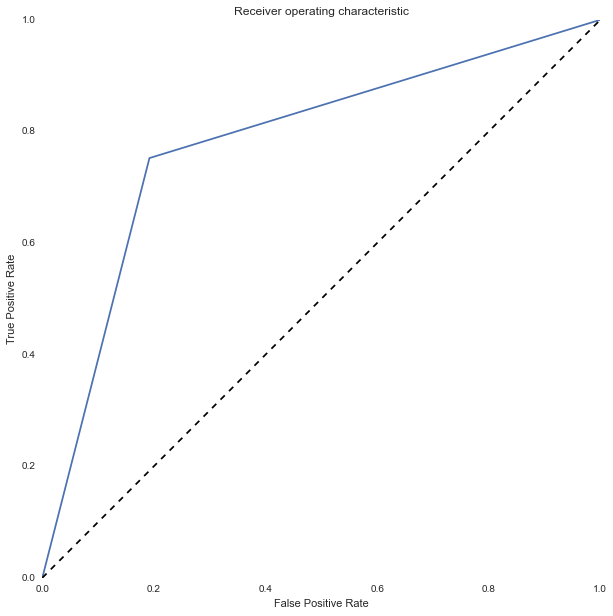

In [209]:
evaluate(booster_predictions)

Correct Prediction count = 6525
Correct Positive Predictions = 2388
Correct Negative Predictions = 4137
Positive Predictions Made = 3209.0
Negative Predictions Made = 5140.0
Overall Accuracy = 0.7815307222421847
Positive Accuracy = 0.7042170451194338
Negative Accuracy = 0.8344090359015732
AUC = 0.77451043575158873


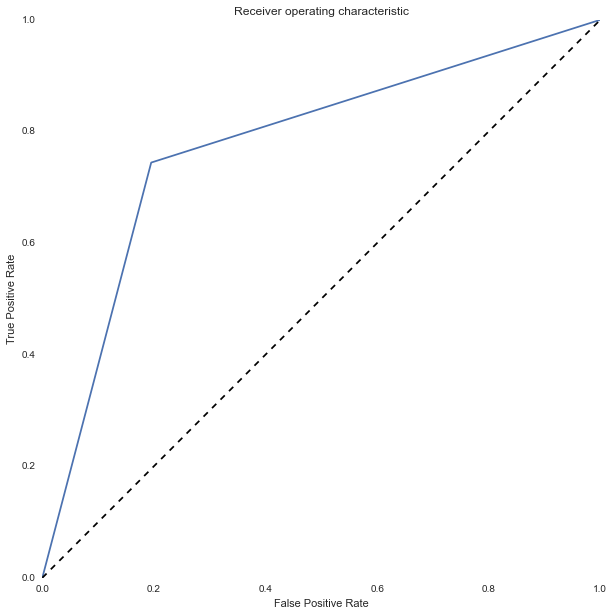

In [210]:
evaluate(forest_predictions)

Correct Prediction count = 6559
Correct Positive Predictions = 2370
Correct Negative Predictions = 4189
Positive Predictions Made = 3139.0
Negative Predictions Made = 5210.0
Overall Accuracy = 0.7856030662354773
Positive Accuracy = 0.698908876437629
Negative Accuracy = 0.8448971359419121
AUC = 0.77952411583820425


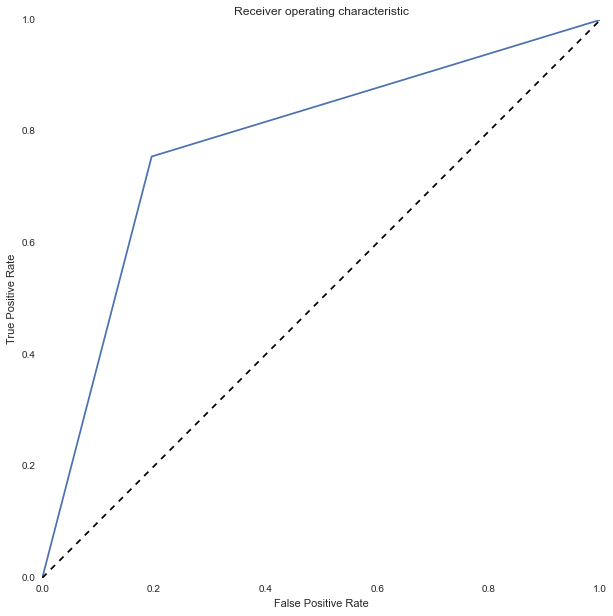

In [211]:
evaluate(logistic_predictions)

Correct Prediction count = 6570
Correct Positive Predictions = 2394
Correct Negative Predictions = 4176
Positive Predictions Made = 3176
Negative Predictions Made = 5173
Overall Accuracy = 0.7869205892921308
Positive Accuracy = 0.7059864346800354
Negative Accuracy = 0.8422751109318274
AUC = 0.78052342355020077


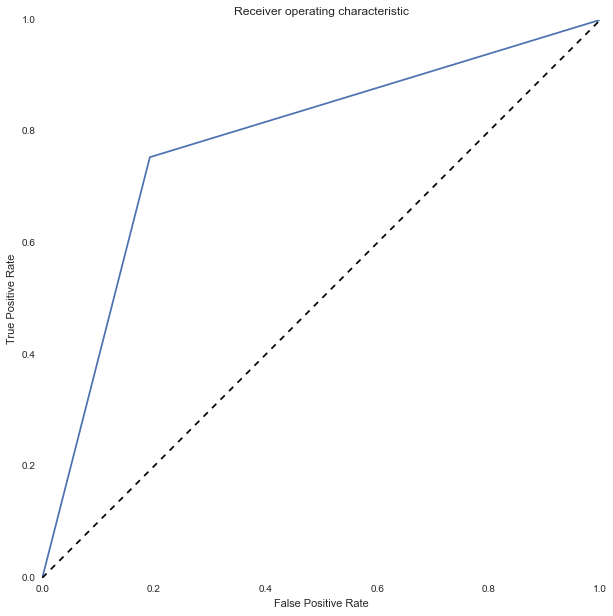

In [212]:
evaluate(blended_predictions)

*Code for selecting interaction terms and parameter tuning*

In [303]:
importances = []
for i in range(len(forest.feature_importances_)):
    importances.append([df.columns[i], forest.feature_importances_[i]])
importances = pd.DataFrame(importances)
importances = importances.sort_index(by = 1, ascending = False)
importances

,0,1
0,avg_dist,0.193203
13,signup_day,0.128329
6,weekday_pct,0.120903
1,avg_rating_by_driver,0.115420
4,surge_pct,0.078271
5,trips_in_first_30_days,0.072823
2,avg_rating_of_driver,0.069477
3,avg_surge,0.064335
8,King's Landing,0.049607
12,True,0.035043


In [308]:
coefficients = []
for i in range(len(logistic.coef_[0])):
    coefficients.append([df.columns[i], abs(logistic.coef_[0][i])])
coefficients = pd.DataFrame(coefficients)
coefficients = coefficients.sort_index(by = 1, ascending = False)
coefficients

,0,1
12,True,0.456261
8,King's Landing,0.442917
5,trips_in_first_30_days,0.442098
7,Astapor,0.327346
10,Android,0.308099
11,iPhone,0.221080
0,avg_dist,0.198417
1,avg_rating_by_driver,0.095861
4,surge_pct,0.072838
9,Winterfell,0.055070


In [ ]:
interaction_terms = pd.DataFrame()
x_train = x_train.rename(columns = {True:'true'})
x_train_copy = x_train.copy()
for i in x_train:
    for j in x_train:
        print i,
        print j,
        print type(j)
        interaction_terms[i + '*' + j] = x_train[i]*x_train_copy[j]
        
        
interaction_terms_test = pd.DataFrame()
x_test = x_test.rename(columns = {True:'true'})
x_test_copy = x_test.copy()
for i in x_test:
    for j in x_test:
        interaction_terms_test[i + '*' + j] = x_test[i]*x_test_copy[j]
        
# ['true*true','weekday_pct*weekday_pct','Android*avg_surge','avg_surge*iPhone','weekday_pct*weekday_pct','King\'s Landing*avg_rating_by_driver','avg_rating_by_driver*King\'s Landing',
#  'avg_rating_by_driver*surge_pct','avg_surge*surge_pct']
        


logistic = linear_model.LogisticRegression()#class_weight='auto'
logistic.fit(interaction_terms, y_train)
logistic_predictions = logistic.predict(interaction_terms_test)
coefficients = []
for i in range(len(logistic.coef_[0])):
    coefficients.append([interaction_terms.columns[i], abs(logistic.coef_[0][i])])
coefficients = pd.DataFrame(coefficients)
coefficients = coefficients.sort_index(by = 1, ascending = False)
coefficients

forest = ensemble.RandomForestClassifier(n_estimators = 100)
forest = forest.fit(interaction_terms, y_train)
forest_predictions = forest.predict(interaction_terms_test)

importances = []
for i in range(len(forest.feature_importances_)):
    importances.append([interaction_terms.columns[i], forest.feature_importances_[i]])
importances = pd.DataFrame(importances)
importances = importances.sort_index(by = 1, ascending = False)
importances
# ['weekday_pct*weekday_pct','King\'s Landing*avg_rating_by_driver','avg_rating_by_driver*King\'s Landing',
#  'avg_rating_by_driver*surge_pct','avg_surge*surge_pct']

In [205]:
def auc(predictions):
    false_positive_rate, true_positive_rate, _ = metrics.roc_curve(predictions, y_test)
    auc = metrics.auc(false_positive_rate, true_positive_rate)
    print "AUC = %r" %auc

for i in range(1, 10):
    n = i * 50
    booster = ensemble.GradientBoostingClassifier(n_estimators = n)
    booster = booster.fit(x_train, y_train)
    booster_predictions = booster.predict(x_test)
    
    forest = ensemble.RandomForestClassifier(n_estimators = n)
    forest = forest.fit(x_train, y_train)
    forest_predictions = forest.predict(x_test)
    
    print "i = %r" %(i*50)
    print "Booster:"
    auc(booster_predictions)
    print "Forest:"
    auc(forest_predictions)
    
    

i = 1
Booster:
AUC = 0.77963666471848825
Forest:
AUC = 0.77059602500706181
i = 2
Booster:
AUC = 0.77761622369462313
Forest:
AUC = 0.77107846536375879
i = 3
Booster:
AUC = 0.77965422091397851
Forest:
AUC = 0.77255555519079877
i = 4
Booster:
AUC = 0.77997404864257713
Forest:
AUC = 0.77209801172270687
i = 5
Booster:
AUC = 0.77759322509708506
Forest:
AUC = 0.76957780389948238
i = 6
Booster:
AUC = 0.77809966062629676
Forest:
AUC = 0.77252006871152523
i = 7
Booster:
AUC = 0.77830540687092986
Forest:
AUC = 0.77060631805464741
i = 8
Booster:
AUC = 0.77613025979465355
Forest:
AUC = 0.772603256324911
i = 9
Booster:
AUC = 0.77651207143807555
Forest:
AUC = 0.77451043575158873
